In [2]:
# Import data from Excel sheet
import pandas as pd
df = pd.read_excel('/data_dzne_archiv2/Studien/Deep_Learning_Visualization/data/ADNI combined.xlsx', sheet_name='sample')
#print(df)
sid = df['RID'] #'subject_ID'
grp = df['Group at scan date (1=CN, 2=EMCI, 3=LMCI, 4=AD, 5=SMC)']
age = df['Age at scan']
sex = df['Sex (1=female)']
tiv = df['TIV_CAT12']
field = df['MRI_Field_Strength']
amybin = df['SUMMARYSUVR_WHOLECEREBNORM_1.11CUTOFF'] #'Amy SUVR Pos'
grpbin = (grp > 1) # 1=CN, ...

In [3]:
# Scan for nifti file names
import glob
dataEMCI = sorted(glob.glob('/data_dzne_archiv2/Studien/Deep_Learning_Visualization/data/mwp1_MNI_ADNI/EMCI/*.nii.gz'))
dataSMC = sorted(glob.glob('/data_dzne_archiv2/Studien/Deep_Learning_Visualization/data/mwp1_MNI_ADNI/SMC/*.nii.gz'))
dataFiles = dataEMCI + dataSMC
numfiles = len(dataFiles)
print('Found ', str(numfiles), ' nifti files')

Found  412  nifti files


In [4]:
import re
import numpy as np
from keras.utils import to_categorical
debug = False
cov_idx = [-1] * numfiles # list; array: np.full((numfiles, 1), -1, dtype=int)
print('Matching covariates for loaded files ...')
for i,id in enumerate(sid):
    p = [j for j,x in enumerate(dataFiles) if re.search('_%04d_' % id, x)] # translate ID numbers to four-digit numbers, get both index and filename
    if len(p)==0:
        if debug: print('Did not find %04d' % id) # did not find Excel sheet subject ID in loaded file selection
    else:
        if debug: print('Found %04d in %s: %s' % (id, p[0], dataFiles[p[0]]))
        cov_idx[p[0]] = i # store Excel index i for data file index p[0]
print('Checking for scans not found in Excel sheet: ', sum(x<0 for x in cov_idx))

labels = pd.DataFrame({'Group':grpbin}).iloc[cov_idx, :]
labels = to_categorical(np.asarray(labels)) # use grps to access original labels
grps = pd.DataFrame({'Group':grp, 'RID':sid}).iloc[cov_idx, :]

Using TensorFlow backend.


Matching covariates for loaded files ...
Checking for scans not found in Excel sheet:  0


In [5]:
# Actually load nifti files into array
import nibabel as nib
import numpy as np
from sklearn import linear_model
# define FOV to reduce required memory size
x_range_from = 10; x_range_to = 110
y_range_from = 13; y_range_to = 133
z_range_from = 5; z_range_to = 105
# 1. dimension: subject
# 2. dimension: img row
# 3. dimension: img col
# 4. dimension: img depth
# 5. dimension: img channel
images = np.zeros((numfiles, z_range_to-z_range_from, x_range_to-x_range_from, y_range_to-y_range_from, 1), dtype=np.float32) # numfiles× z × x × y ×1; avoid 64bit types
#print(images.shape)

for i in range(numfiles):   # for loop over files and load
  if (i % 50 == 0):
    print('Loading file %d of %d' % (i+1, numfiles))
  img = nib.load(dataFiles[i])
  img = img.get_fdata()[x_range_from:x_range_to, y_range_from:y_range_to, z_range_from:z_range_to]
  img = np.transpose(img, (2, 0, 1)) # reorder dimensions to match coronal view z*x*y in MRIcron etc.
  #img = np.fliplr(img) # flip upside down and
  #img = np.flipud(img) # left/right to match MRIcroN views when plotted directly
  #img = np.flip(img, 2) # flip front/back
  img = np.flip(img) # flip all positions
  #print(img.shape)
  images[i, :,:,:, 0] = np.nan_to_num(img)
print('Successfully loaded files')
print('Image array size: ', images.shape)

Loading file 1 of 412
Loading file 51 of 412
Loading file 101 of 412
Loading file 151 of 412
Loading file 201 of 412
Loading file 251 of 412
Loading file 301 of 412
Loading file 351 of 412
Loading file 401 of 412
Successfully loaded files
Image array size:  (412, 100, 100, 120, 1)


In [6]:
# save original images array to disk
import h5py
hf = h5py.File('orig_images_ADNI2_EMCI_SMC_wb_mwp1_CAT12_MNI.hdf5', 'w')
hf.create_dataset('images', data=images, compression='gzip')
hf.close()

displaying image  /data_dzne_archiv2/Studien/Deep_Learning_Visualization/data/mwp1_MNI_ADNI/EMCI/mwp1ADNI_005_S_4185_MR_MT1__GradWarp__N3m_Br_20120203161103643_S135524_I282717.nii.gz


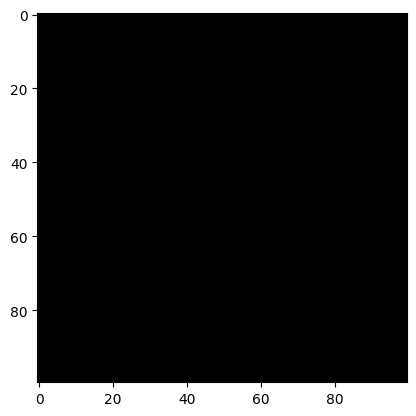

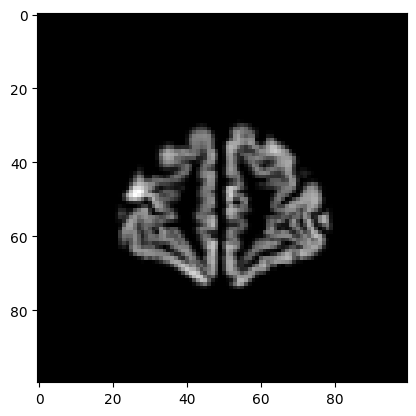

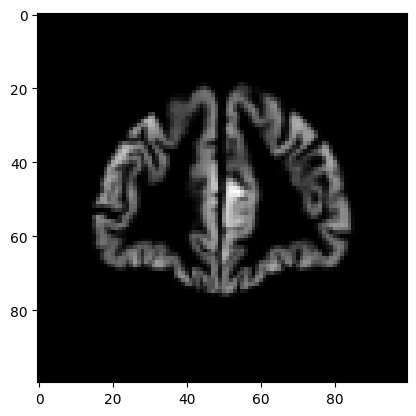

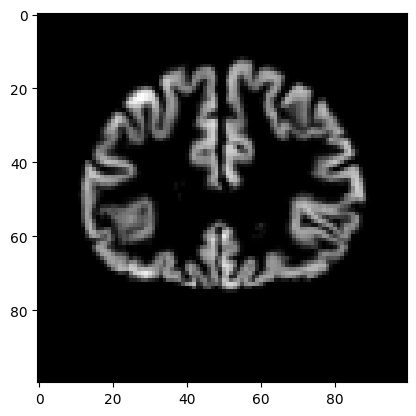

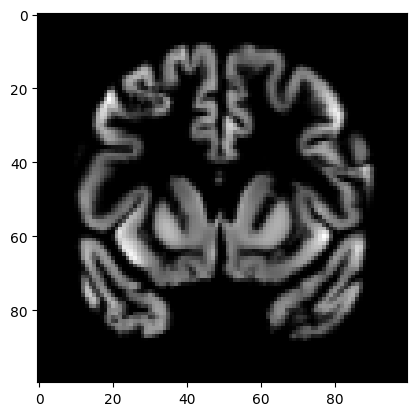

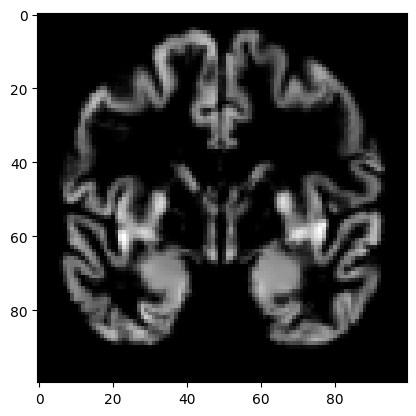

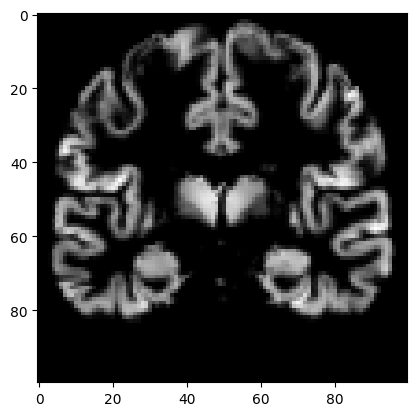

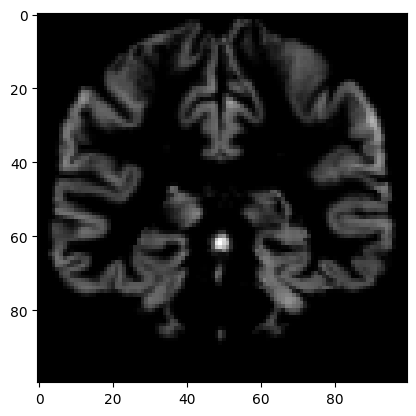

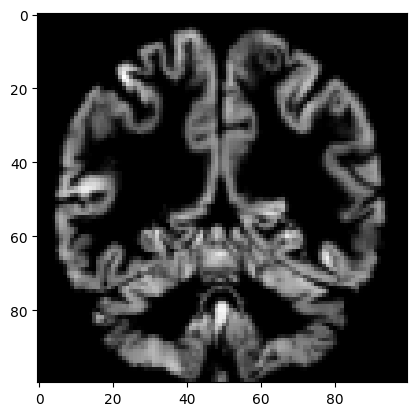

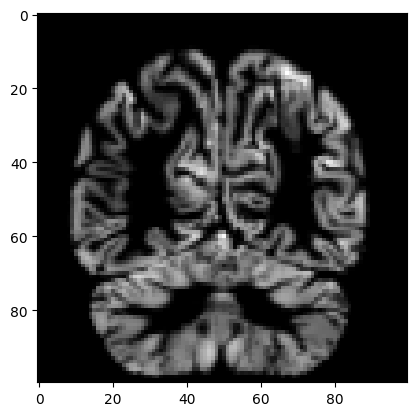

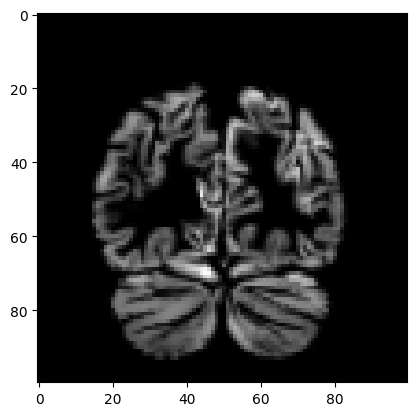

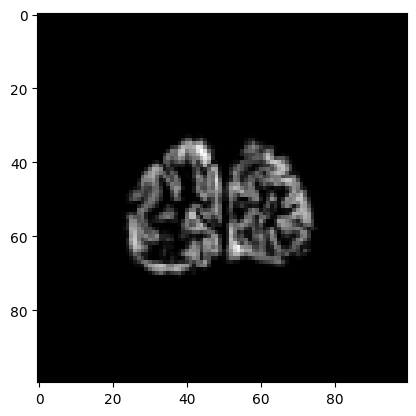

In [7]:
# Display a single scan
from matplotlib import pyplot as plt
%matplotlib inline
#import numpy as np
test_img = images[0, :,:,:, 0]
ma = np.max(test_img)
mi = np.min(test_img)
test_img = (test_img - mi) / (ma - mi) # normalising to (0-1) range
#test_img = (test_img - test_img.mean())/test_img.std() # normalizing by mean and sd
print('displaying image ', dataFiles[0])
for i in range(test_img.shape[2]):
  if (i % 10 == 0): # only display each tenth slice
    plt.figure()
    a = test_img[:,:,i]
    plt.imshow(a, cmap='gray')

In [8]:
# Perform regression-based covariates cleaning
from sklearn import linear_model
from pandas import DataFrame

covariates = DataFrame({'Age':age, 'Sex':sex, 'TIV':tiv, 'FieldStrength':field}).iloc[cov_idx, :]
print("Covariates data frame size : ", covariates.shape)
print(covariates.head())
#print(label.head())
covariates = covariates.to_numpy(dtype=np.float32) # convert dataframe to nparray with 32bit types

# not run: estimate model using AIBL controls -> instead apply ADNI2 model
##covCN = covariates[labels['Group'] == 0] # only controls as reference group to estimate effect of covariates
##print("Controls covariates data frame size : ", covCN.shape)
# load coefficients for linear models from hdf5
hf = h5py.File('linear_models_ADNI2.hdf5', 'r')
hf.keys  # read keys
lmarray = np.array(hf.get('linearmodels'), dtype=np.float32)  # stores 4 coefficients + 1 intercept per voxel
hf.close()
lm = linear_model.LinearRegression()

for k in range(images.shape[3]):
  print('Processing depth slice ', str(k+1), ' of ', str(images.shape[3]))
  for j in range(images.shape[2]):
    for i in range(images.shape[1]):
      if any(images[:, i, j, k, 0] != 0):
        # not run: estimate model using AIBL controls -> instead apply ADNI2 model
        ##tmpdat = images[labels['Group'] == 0, i, j, k, 0]
        ##lm.fit(covCN, tmpdat) # estimate model coefficients (intercept added automatically)
        # take model coefficients from ADNI2 file
        lm.coef_ = lmarray[k, j, i, :4]
        lm.intercept_ = lmarray[k, j, i, 4]
        pred = lm.predict(covariates) # calculate prediction for all subjects
        images[:, i, j, k, 0] = images[:, i, j, k, 0] - pred # % subtract effect of covariates from original values (=calculate residuals)

Covariates data frame size :  (412, 4)
      Age  Sex      TIV  FieldStrength
409  81.0    0  1408.82            3.0
295  68.0    0  1786.24            3.0
889  70.0    0  1710.66            3.0
291  58.0    1  1299.59            3.0
899  72.0    0  1506.47            3.0
Processing depth slice  1  of  120
Processing depth slice  2  of  120
Processing depth slice  3  of  120
Processing depth slice  4  of  120
Processing depth slice  5  of  120
Processing depth slice  6  of  120
Processing depth slice  7  of  120
Processing depth slice  8  of  120
Processing depth slice  9  of  120
Processing depth slice  10  of  120
Processing depth slice  11  of  120
Processing depth slice  12  of  120
Processing depth slice  13  of  120
Processing depth slice  14  of  120
Processing depth slice  15  of  120
Processing depth slice  16  of  120
Processing depth slice  17  of  120
Processing depth slice  18  of  120
Processing depth slice  19  of  120
Processing depth slice  20  of  120
Processing depth

In [9]:
# Save residualized data to disk
import h5py
hf = h5py.File('residuals_ADNI2_EMCI_SMC_wb_mwp1_CAT12_MNI.hdf5', 'w')
hf.create_dataset('images', data=images, compression='gzip')
# don't store Strings or String arrays in HDF5 containers as this is problematic
hf.close()

displaying residual image  /data_dzne_archiv2/Studien/Deep_Learning_Visualization/data/mwp1_MNI_ADNI/EMCI/mwp1ADNI_005_S_4185_MR_MT1__GradWarp__N3m_Br_20120203161103643_S135524_I282717.nii.gz


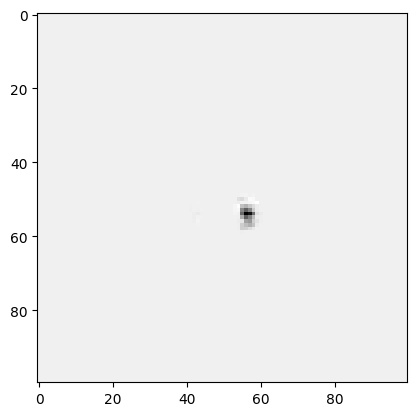

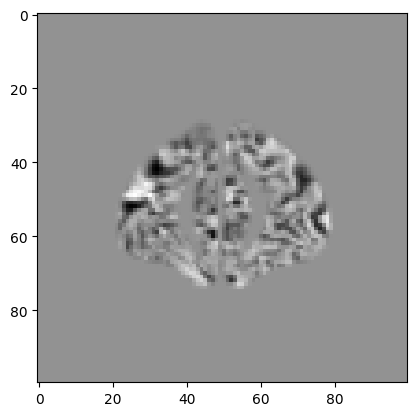

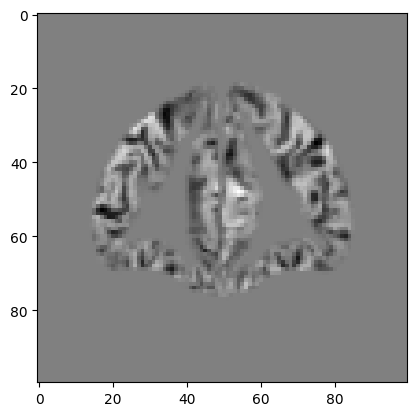

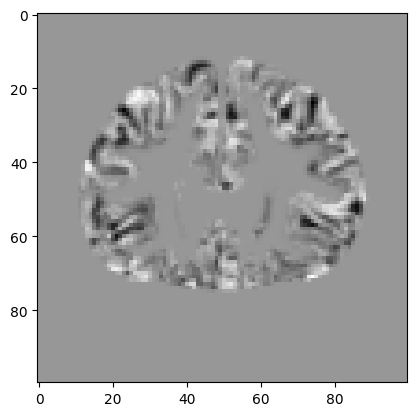

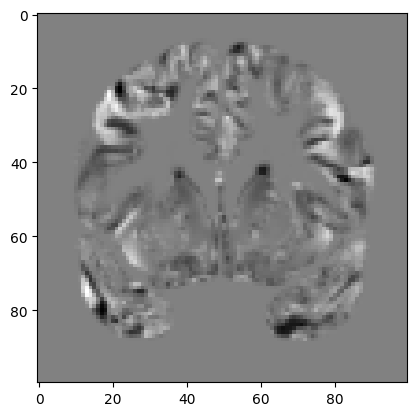

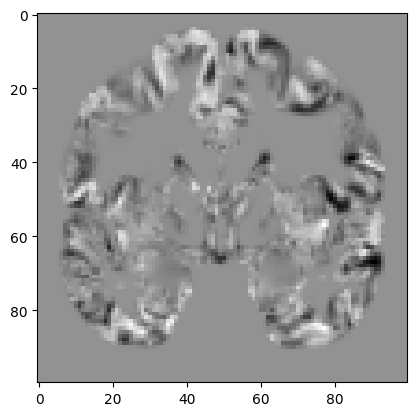

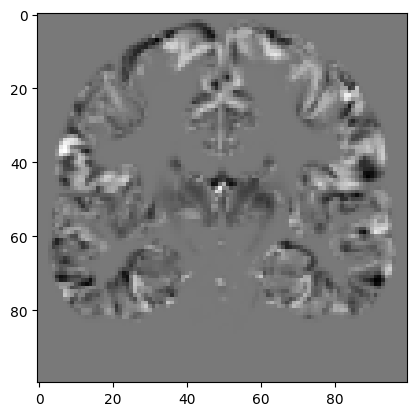

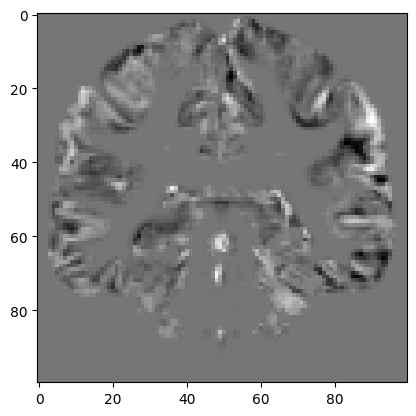

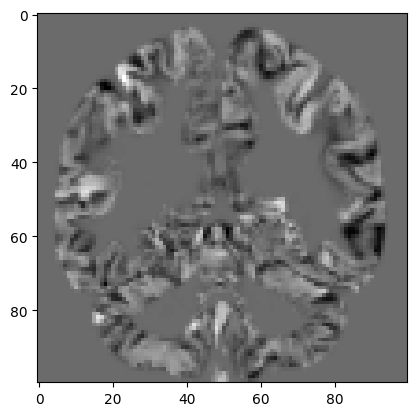

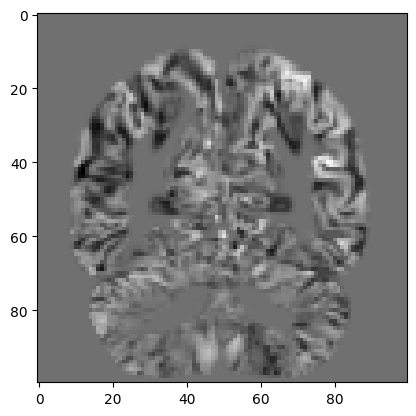

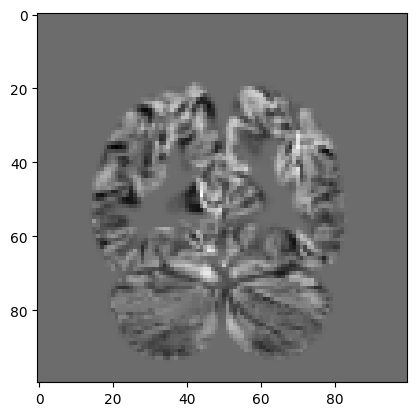

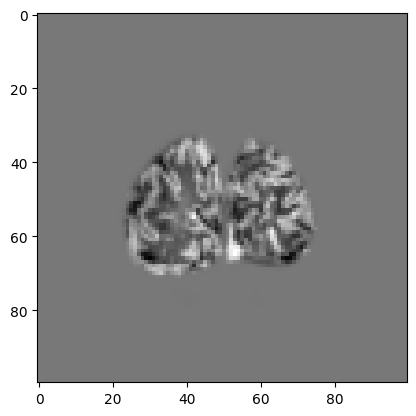

In [10]:
# Display a single scan (residuals)
from matplotlib import pyplot as plt
#import numpy as np
test_img = images[0, :,:,:, 0]
ma = np.max(test_img)
mi = np.min(test_img)
test_img = (test_img - mi) / (ma - mi) # normalising to (0-1) range
#test_img = (test_img - test_img.mean())/test_img.std() # normalizing by mean and sd
print('displaying residual image ', dataFiles[0])
for i in range(test_img.shape[2]):
  if (i % 10 == 0): # only display each fifth slice
    plt.figure()
    a = test_img[:,:,i]
    plt.imshow(a, cmap='gray')

In [ ]:
#Load residualized data from disk
import h5py
hf = h5py.File('residuals_ADNI2_EMCI_SMC_wb_mwp1_CAT12_MNI.hdf5', 'r')
hf.keys # read keys
images = np.array(hf.get('images'))
hf.close()

In [11]:
import tensorflow as tf
print(tf.__version__)

# disable tensorflow deprecation warnings
import logging
logging.getLogger('tensorflow').disabled=True

from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto(
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=1)
    # device_count = {'GPU': 1}
)
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
set_session(session)

1.15.5


2023-12-01 09:41:23.386882: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-12-01 09:41:23.394729: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3192500000 Hz
2023-12-01 09:41:23.395280: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4fb7c30 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-12-01 09:41:23.395303: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-12-01 09:41:23.398344: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-12-01 09:41:23.503505: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-01 09:41:23.50378

In [12]:
import nibabel as nib

# define FOV to reduce required memory size
x_range_from = 10; x_range_to = 110
y_range_from = 13; y_range_to = 133
z_range_from = 5; z_range_to = 105

data_overlay = sorted(glob.glob('Hippocampus_masks/aal_hippocampus.nii*'))

In [13]:
# Load CNN model from disk --> save predictions
from keras.models import load_model

batch_size = 20

for k in [0]: #range(20):
    mymodel = load_model('model_checkpoints/resmodel_wb_whole_ds.hdf5') #load_model('model_checkpoints/resmodel_wb_cv%d.best.hdf5' % (k+1))
    #mymodel.summary()
    pred = mymodel.predict(images, batch_size=batch_size)
    # only output prediction scores for AD output neuron
    results = pd.DataFrame({'SID':grps.RID, 'Group':grps.Group, 'pred':pred[:,1]})
    results.to_csv('results_wholeds_ADNI2_EMCI_SMC_predictions.csv')

2023-12-01 09:41:26.191697: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2023-12-01 09:41:26.478407: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-12-01 09:41:27.499654: W tensorflow/stream_executor/cuda/redzone_allocator.cc:312] Not found: ./bin/ptxas not found
Relying on driver to perform ptx compilation. This message will be only logged once.


In [14]:
# Load CNN model from disk
from keras.models import load_model, Model
#!pip install innvestigate
import innvestigate
import innvestigate.utils as iutils
import numpy as np
from matplotlib import pyplot as plt
import scipy
import csv


# see https://github.com/albermax/innvestigate/blob/master/examples/notebooks/imagenet_compare_methods.ipynb for a list of alternative methods
methods = [ # tuple with method,     params,                  label
#            ("deconvnet",            {},                      "Deconvnet"),
#            ("guided_backprop",      {},                      "Guided Backprop"),
#            ("deep_taylor.bounded",  {"low": -1, "high": 1},  "DeepTaylor"),
#            ("input_t_gradient",     {},                      "Input * Gradient"),
#            ("lrp.z",                {},                      "LRP-Z"),
#            ("lrp.epsilon",          {"epsilon": 1},          "LRP-epsilon"),
#            ("lrp.alpha_1_beta_0",   {"neuron_selection_mode":"index"},     "LRP-alpha1beta0"),
        ("lrp.sequential_preset_a", {"neuron_selection_mode": "index", "epsilon": 1e-10}, "LRP-CMPalpha1beta0"), # LRP CMP rule taken from https://github.com/berleon/when-explanations-lie/blob/master/when_explanations_lie.py
]

hipp_nifti = nib.load(data_overlay[0])  # assume it is already 32bit float format
new_data = np.zeros((121, 145, 121), dtype=np.float32) 

for k in [0]: #range(20):
    mymodel = load_model('model_checkpoints/resmodel_wb_whole_ds.hdf5') #load_model('model_checkpoints/resmodel_wb_cv%d.best.hdf5' % (k+1))
    #mymodel.summary()
    #model_wo_softmax = iutils.keras.graph.model_wo_softmax(mymodel)  ## sometimes raises: ValueError: The name "dense_1" is used 2 times in the model. All layer names should be unique.
    #model_wo_softmax = Model(inputs=mymodel.inputs,
    #                          outputs=iutils.keras.graph.pre_softmax_tensors(mymodel.outputs),
    #                          name=(mymodel.name + '_wo_softmax')) 
    #model_wo_softmax.summary()
    mymodel.layers[-1].activation=tf.keras.activations.linear
    mymodel.save('tmp_wo_softmax.hdf5')
    model_wo_softmax = load_model('tmp_wo_softmax.hdf5')
    if (k==0):
        model_wo_softmax.summary()

    # create analyzer
    analyzers = []
    for method in methods:
        #analyzer = innvestigate.create_analyzer("deep_taylor.bounded", model_wo_softmax, **params )
        analyzer = innvestigate.create_analyzer(method[0], model_wo_softmax, **method[1])
        # Some analyzers require training.
        #   analyzer.fit(test_img, batch_size=30, verbose=1)
        #  analyzers.append(analyzer)
     
    for indx in range(len(grps)):
        test_img = images[indx]
        #test_orig = images_orig[indx]
        #print('test image for subject of binary group: %d' % test_Y[subj_idx, 1]) # first col will indicate CN, second col indicates MCI/AD
        #print('test image for subject of ADNI diagnosis: %d [1-CN, 3-LMCI, 4-AD]' % testgrps.Group.to_numpy(dtype=np.int)[subj_idx])

        ####print('test subject ID %s' % grps.RID.to_numpy(dtype=np.int)[indx])

        test_img = np.reshape(test_img, (1,)+ test_img.shape) # add first subj index again to mimic original array structure
        #test_orig = np.reshape(test_orig, (1,)+ test_orig.shape) # add first subj index again to mimic original array structure

        #for method,analyzer in zip(methods, analyzers):
        a = np.reshape(analyzer.analyze(test_img, neuron_selection=1), test_img.shape[1:4])
        #np.clip(a, a_min=0, a_max=None, out=a)
        #a = scipy.ndimage.filters.gaussian_filter(a, sigma=0.8) # smooth activity image
        #scale = np.quantile(a, 0.99) # no need for abs(a)
        #if scale!=0:  # ignore if relevance maps contains only zeros, output will be zero as well
        #    a = (a/scale)

        a = np.flip(a) # flip all positions
        a = np.transpose(a, (1, 2, 0)) # reorder dimensions from coronal view z*x*y back to x*y*z

        print('saving lrp_maps_ADNI2/lrp_map_grp%d_%04d_whole_ds_model.nii' % (grps.Group.iloc[indx], grps.RID.iloc[indx])) #'saving lrp_map_grp%d_%04d_cv%d.nii' % (grps.Group.iloc[indx], grps.RID.iloc[indx], (k+1)))
        new_data[x_range_from:x_range_to, y_range_from:y_range_to, z_range_from:z_range_to] = a
        nifti = nib.Nifti1Image(new_data, hipp_nifti.affine, hipp_nifti.header)
        nifti.to_filename('lrp_maps_ADNI2/lrp_map_grp%d_%04d_whole_ds_model.nii' % (grps.Group.iloc[indx], grps.RID.iloc[indx])) #'lrp_map_grp%d_%04d_cv%d.nii' % (grps.Group.iloc[indx], grps.RID.iloc[indx], (k+1)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 100, 100, 120, 5)  140       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 50, 50, 60, 5)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 60, 5)     20        
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 50, 50, 60, 5)     680       
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 25, 25, 30, 5)     0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 25, 25, 30, 5)     20        
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 25, 25, 30, 5)     680       
__________

saving lrp_maps_ADNI2/lrp_map_grp2_2185_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp2_2187_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp2_2190_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp2_2191_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp2_2193_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp2_2194_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp2_2195_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp2_2196_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp2_2199_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp2_2200_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp2_2201_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp2_2205_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp2_2208_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp2_2210_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp2_2213_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp2_2216_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp2_2219_whole_ds_model.n

saving lrp_maps_ADNI2/lrp_map_grp2_4517_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp2_4522_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp2_4530_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp2_4536_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp2_4539_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp2_4540_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp2_4547_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp2_4553_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp2_4556_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp2_4557_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp2_4565_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp2_4571_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp2_4594_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp2_4597_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp2_4601_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp2_4610_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp2_4613_whole_ds_model.n

saving lrp_maps_ADNI2/lrp_map_grp5_5295_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp5_5159_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp5_5212_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp5_5167_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp5_5227_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp5_5278_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp5_5279_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp5_5282_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp5_5075_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp5_5091_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp5_5096_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp5_5102_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp5_5280_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp5_5234_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp5_5214_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp5_5243_whole_ds_model.nii
saving lrp_maps_ADNI2/lrp_map_grp5_5132_whole_ds_model.n